In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


# Import Data

In [2]:
# Import Data
us = pd.read_csv('univariate_datasets/univariate_df_United_States.csv',usecols=[1,2],  parse_dates=[0]).reset_index(drop=True)
us.columns = ['ds', 'y']
belgium = pd.read_csv('univariate_datasets/univariate_df_Belgium.csv', usecols=[1,2], parse_dates = [0]).reset_index(drop=True)
belgium.columns = ['ds', 'y']
chile = pd.read_csv('univariate_datasets/univariate_df_Chile.csv', usecols=[1,2], parse_dates = [0]).reset_index(drop=True)
chile.columns = ['ds', 'y']
czechia = pd.read_csv('univariate_datasets/univariate_df_Czechia.csv', usecols=[1,2], parse_dates = [0]).reset_index(drop=True)
czechia.columns = ['ds', 'y']
estonia = pd.read_csv('univariate_datasets/univariate_df_Estonia.csv', usecols=[1,2], parse_dates = [0]).reset_index(drop=True)
estonia.columns = ['ds', 'y']
france = pd.read_csv('univariate_datasets/univariate_df_France.csv', usecols=[1,2], parse_dates = [0]).reset_index(drop=True)
france.columns = ['ds', 'y']
ireland = pd.read_csv('univariate_datasets/univariate_df_Ireland.csv', usecols=[1,2], parse_dates = [0]).reset_index(drop=True)
ireland.columns = ['ds', 'y']
israel = pd.read_csv('univariate_datasets/univariate_df_Israel.csv', usecols=[1,2], parse_dates = [0]).reset_index(drop=True)
israel.columns = ['ds', 'y']
italy = pd.read_csv('univariate_datasets/univariate_df_Italy.csv', usecols=[1,2], parse_dates = [0]).reset_index(drop=True)
italy.columns = ['ds', 'y']
malaysia = pd.read_csv('univariate_datasets/univariate_df_Malaysia.csv', usecols=[1,2], parse_dates = [0]).reset_index(drop=True)
malaysia.columns = ['ds', 'y']


# test_train split
train_size = int(len(us)*0.8)

small_constant = 1
def mape(y_true, prediction):
    return np.mean(np.abs((y_true - prediction) / (y_true + small_constant))) * 100
mase = MeanAbsoluteScaledError(sp=13)

evaluation = pd.DataFrame(columns = ['Country','Model', 'MAE', 'MAPE'])

# US

21:43:03 - cmdstanpy - INFO - Chain [1] start processing
21:43:03 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_20579/2108262189.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':'United States',
21:43:03 - cmdstanpy - INFO - Chain [1] start processing
21:43:03 - cmdstanpy - INFO - Chain [1] done processing
21:43:06 - cmdstanpy - INFO - Chain [1] start processing
21:43:06 - cmdstanpy - INFO - Chain [1] start processing
21:43:06 - cmdstanpy - INFO - Chain [1] start processing
21:43:06 - cmdstanpy - INFO - Chain

,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.670420,0.198496
1,United States,Tuned,6637.052246,16182.511291,1.207254


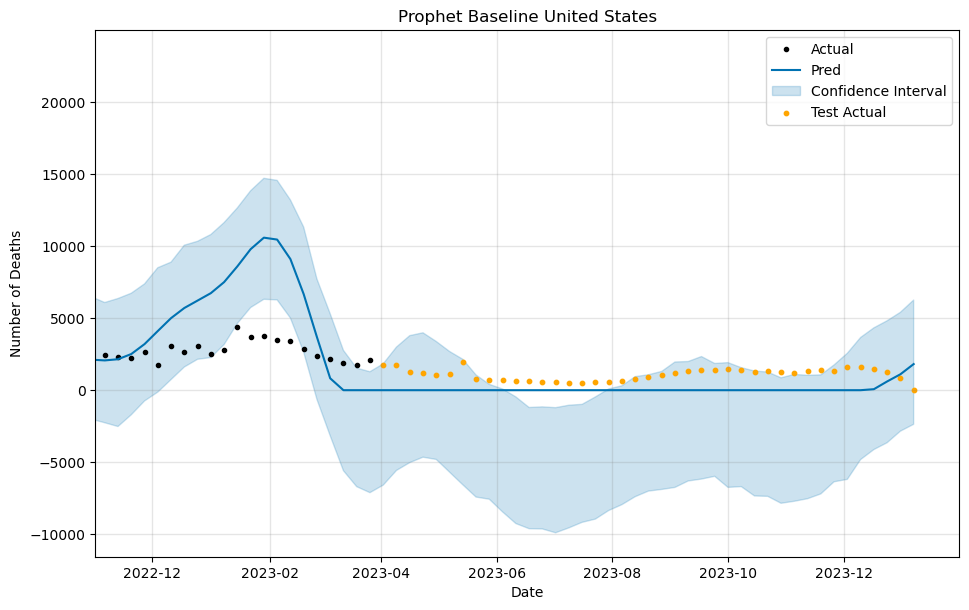

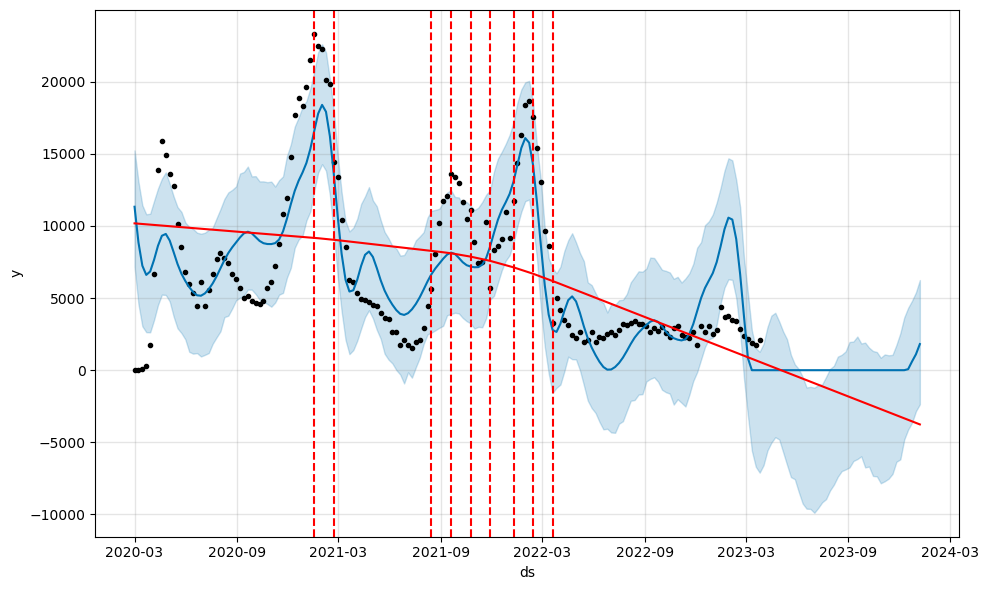

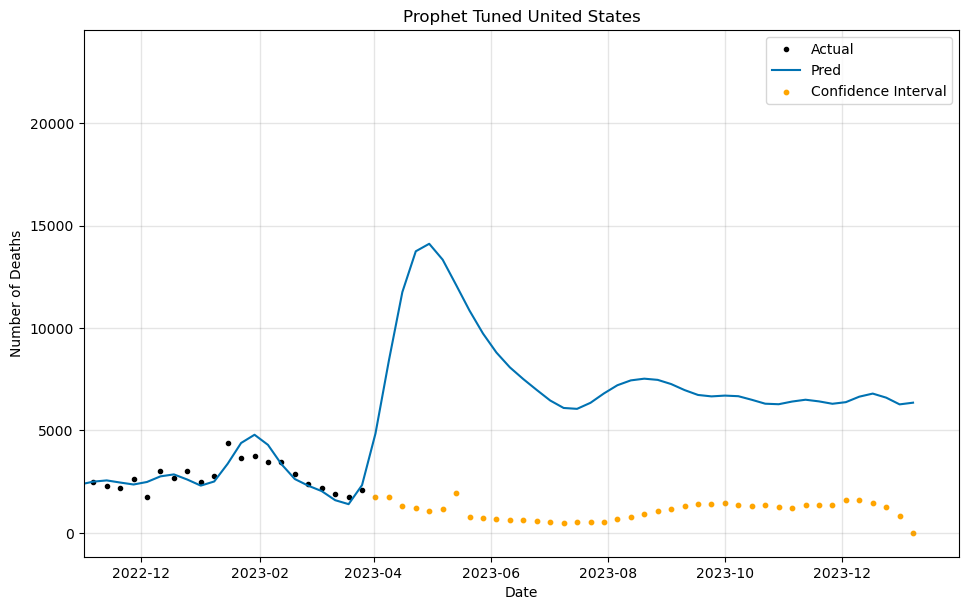

In [3]:
df = us 
train, test = df[0:train_size], df[train_size:]

# baseline prophet model
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(train)

# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Baseline United States')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'United States', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)

# tuning prophet 

param_grid = {'changepoint_prior_scale': [0.01, 0.1, 0.5,1.0,10.0],
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='56 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
best_params = all_params[np.argmin(maes)]

model_changepoint = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], seasonality_prior_scale=best_params['seasonality_prior_scale'])
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint, uncertainty=False); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Tuned United States')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':'United States', 
                                'Model':'Tuned', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

# Belgium

21:44:46 - cmdstanpy - INFO - Chain [1] start processing


21:44:46 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_20579/217431124.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':' Belgium',
21:44:46 - cmdstanpy - INFO - Chain [1] start processing
21:44:46 - cmdstanpy - INFO - Chain [1] done processing
21:44:49 - cmdstanpy - INFO - Chain [1] start processing
21:44:49 - cmdstanpy - INFO - Chain [1] start processing
21:44:49 - cmdstanpy - INFO - Chain [1] start processing
21:44:49 - cmdstanpy - INFO - Chain [1] start processing
21:44:49 - cmdstanpy - INFO - Chain [1] s

,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.670420,0.198496
1,United States,Tuned,6637.052246,16182.511291,1.207254
2,Belgium,Baseline,57.538519,2312.254946,0.242626
3,Belgium,Tuned,8.642080,33.644019,0.036442


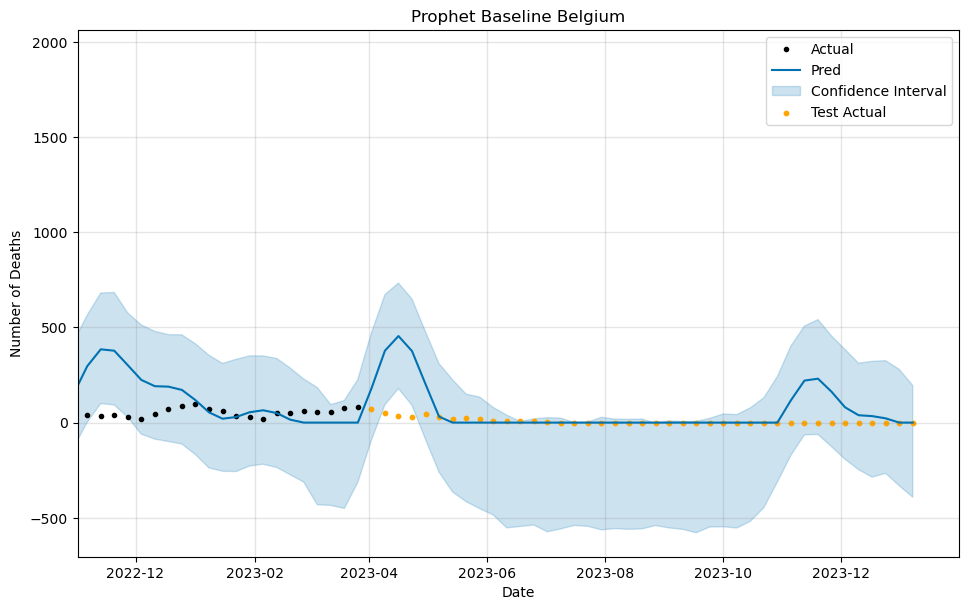

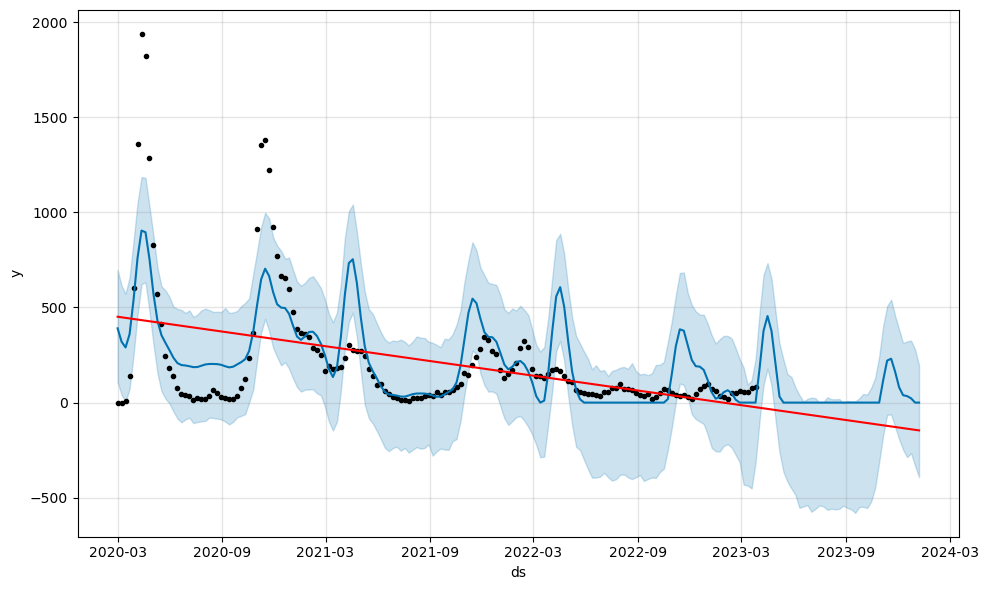

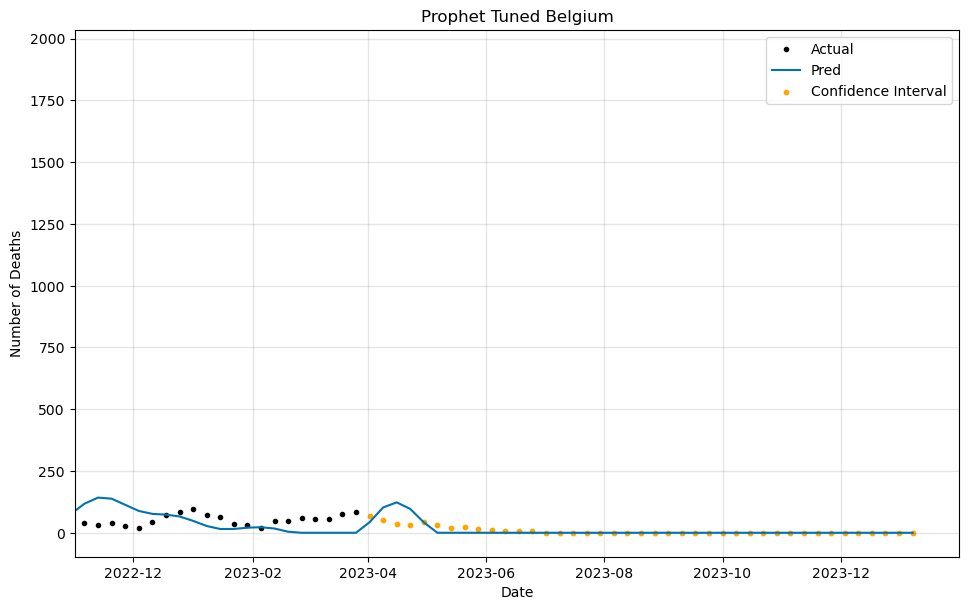

In [4]:
df = belgium 
train, test = df[0:train_size], df[train_size:]

# baseline prophet model
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(train)

# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Baseline Belgium')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':' Belgium', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)

# tuning prophet 

param_grid = {'changepoint_prior_scale': [0.01, 0.1, 0.5,1.0,10.0],
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='56 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
best_params = all_params[np.argmin(maes)]

model_changepoint = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], seasonality_prior_scale=best_params['seasonality_prior_scale'])
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint, uncertainty=False); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Tuned Belgium')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':' Belgium', 
                                'Model':'Tuned', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

# Chile

21:46:16 - cmdstanpy - INFO - Chain [1] start processing
21:46:16 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_20579/1004921450.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':' Chile',
21:46:16 - cmdstanpy - INFO - Chain [1] start processing
21:46:16 - cmdstanpy - INFO - Chain [1] done processing
21:46:18 - cmdstanpy - INFO - Chain [1] start processing
21:46:18 - cmdstanpy - INFO - Chain [1] start processing
21:46:18 - cmdstanpy - INFO - Chain [1] start processing
21:46:18 - cmdstanpy - INFO - Chain [1] st

,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.670420,0.198496
1,United States,Tuned,6637.052246,16182.511291,1.207254
2,Belgium,Baseline,57.538519,2312.254946,0.242626
3,Belgium,Tuned,8.642080,33.644019,0.036442
4,Chile,Baseline,214.633967,2422.805759,0.488097
5,Chile,Tuned,82.871212,497.925852,0.188457


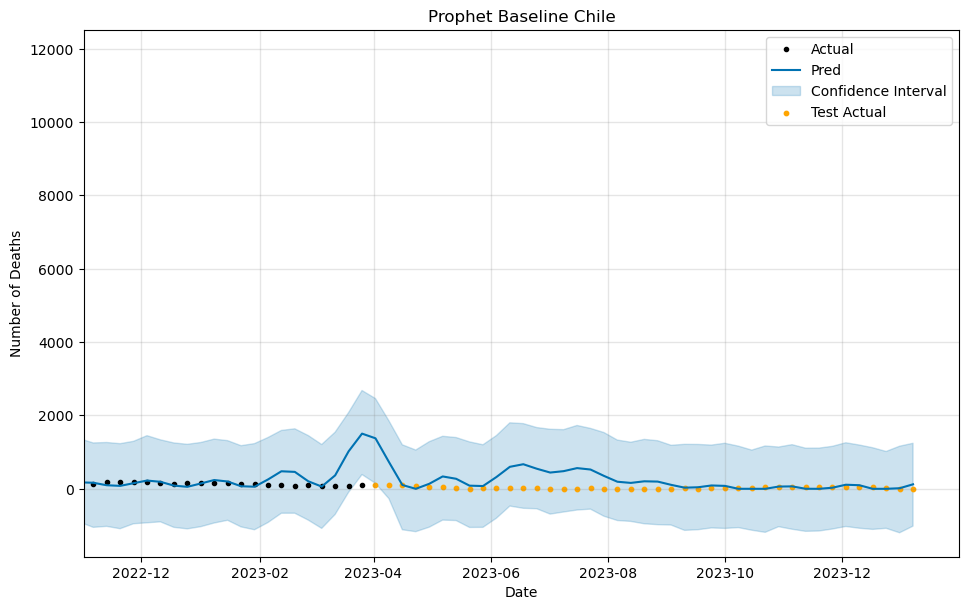

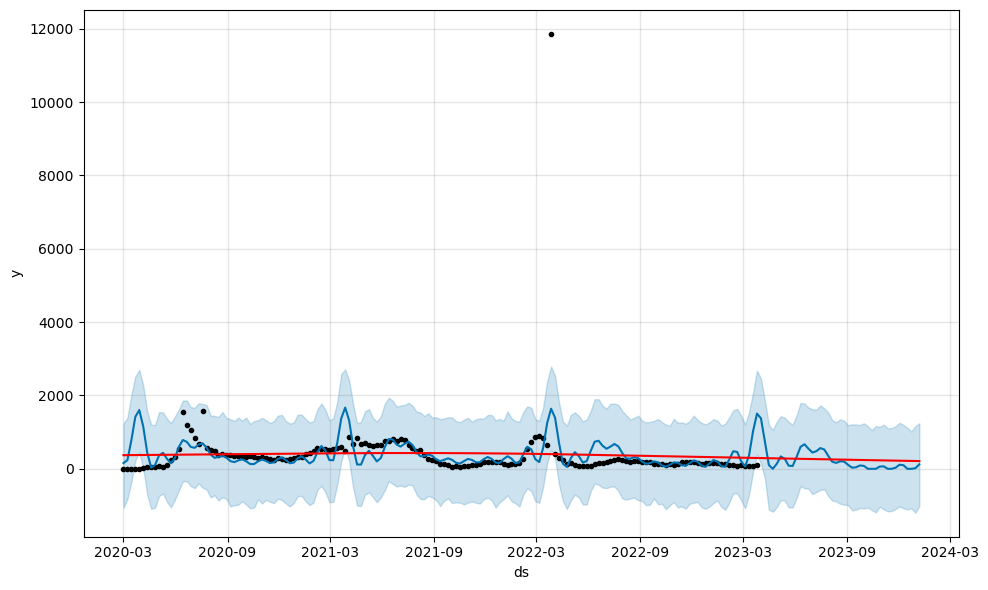

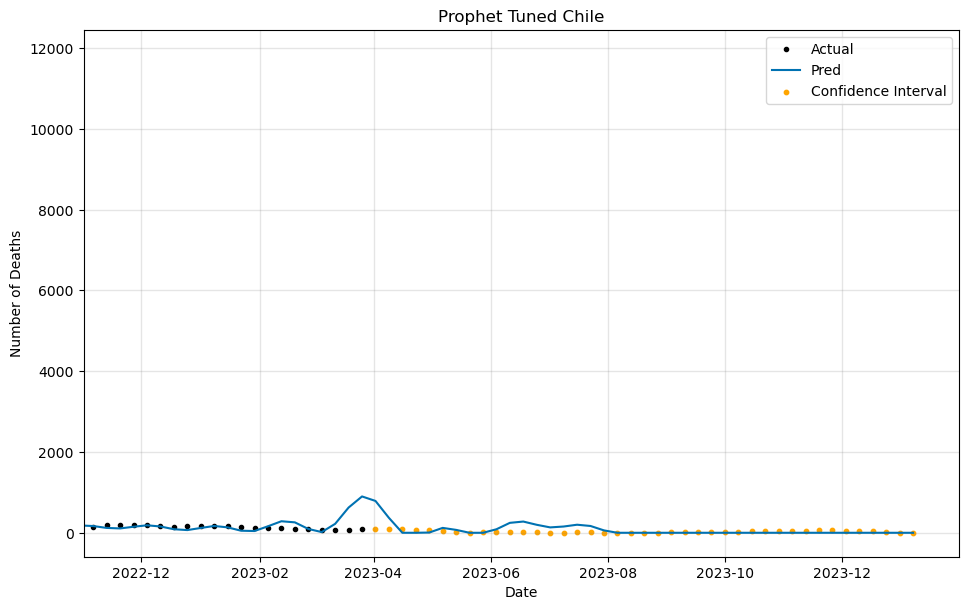

In [5]:
df = chile 
train, test = df[0:train_size], df[train_size:]

# baseline prophet model
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(train)

# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Baseline Chile')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':' Chile', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)

# tuning prophet 

param_grid = {'changepoint_prior_scale': [0.01, 0.1, 0.5,1.0,10.0],
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='56 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
best_params = all_params[np.argmin(maes)]

model_changepoint = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], seasonality_prior_scale=best_params['seasonality_prior_scale'])
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint, uncertainty=False); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Tuned Chile')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':' Chile', 
                                'Model':'Tuned', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

# Czechia

21:47:43 - cmdstanpy - INFO - Chain [1] start processing
21:47:43 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_20579/3067114232.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':' Chile',
21:47:43 - cmdstanpy - INFO - Chain [1] start processing
21:47:43 - cmdstanpy - INFO - Chain [1] done processing
21:47:45 - cmdstanpy - INFO - Chain [1] start processing
21:47:45 - cmdstanpy - INFO - Chain [1] start processing
21:47:45 - cmdstanpy - INFO - Chain [1] start processing
21:47:45 - cmdstanpy - INFO - Chain [1] st

,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.670420,0.198496
1,United States,Tuned,6637.052246,16182.511291,1.207254
2,Belgium,Baseline,57.538519,2312.254946,0.242626
3,Belgium,Tuned,8.642080,33.644019,0.036442
4,Chile,Baseline,214.633967,2422.805759,0.488097
5,Chile,Tuned,82.871212,497.925852,0.188457
6,Chile,Baseline,16.468927,71.162596,0.051739
7,Czechia,Tuned,16.507045,69.033493,0.051858


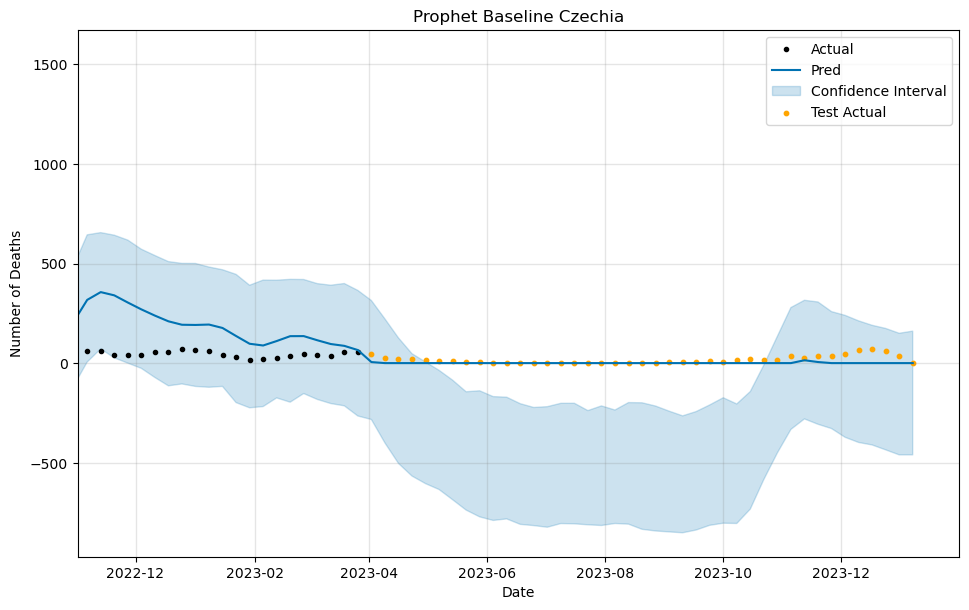

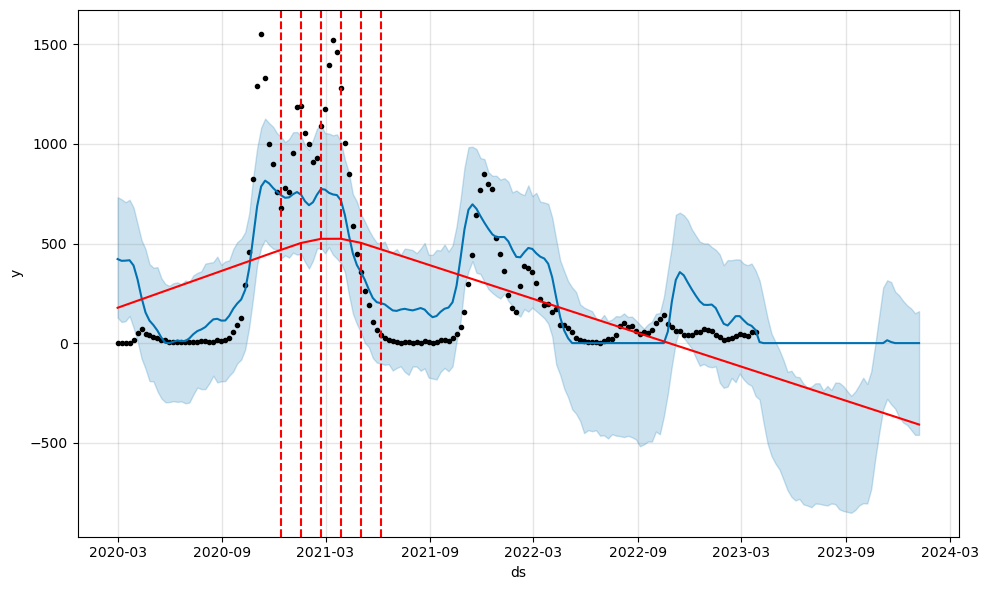

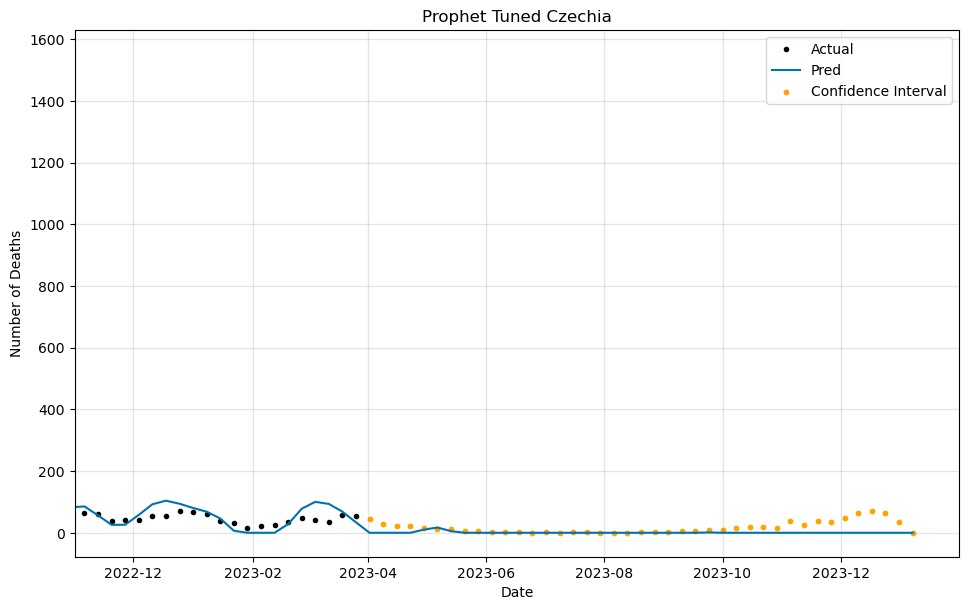

In [6]:
df = czechia 
train, test = df[0:train_size], df[train_size:]

# baseline prophet model
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(train)

# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Baseline Czechia')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':' Czechia', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)

# tuning prophet 

param_grid = {'changepoint_prior_scale': [0.01, 0.1, 0.5,1.0,10.0],
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='56 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
best_params = all_params[np.argmin(maes)]

model_changepoint = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], seasonality_prior_scale=best_params['seasonality_prior_scale'])
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint, uncertainty=False); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Tuned Czechia')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':' Czechia', 
                                'Model':'Tuned', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

# Estonia

21:49:17 - cmdstanpy - INFO - Chain [1] start processing
21:49:17 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_20579/590426014.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':' Estonia',
21:49:18 - cmdstanpy - INFO - Chain [1] start processing
21:49:18 - cmdstanpy - INFO - Chain [1] done processing
21:49:20 - cmdstanpy - INFO - Chain [1] start processing
21:49:20 - cmdstanpy - INFO - Chain [1] start processing
21:49:20 - cmdstanpy - INFO - Chain [1] start processing
21:49:20 - cmdstanpy - INFO - Chain [1] s

,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.670420,0.198496
1,United States,Tuned,6637.052246,16182.511291,1.207254
2,Belgium,Baseline,57.538519,2312.254946,0.242626
3,Belgium,Tuned,8.642080,33.644019,0.036442
4,Chile,Baseline,214.633967,2422.805759,0.488097
5,Chile,Tuned,82.871212,497.925852,0.188457
6,Chile,Baseline,16.468927,71.162596,0.051739
7,Czechia,Tuned,16.507045,69.033493,0.051858
8,Estonia,Baseline,3.166873,51.833376,0.163366
9,Estonia,Tuned,3.061283,45.982188,0.157919


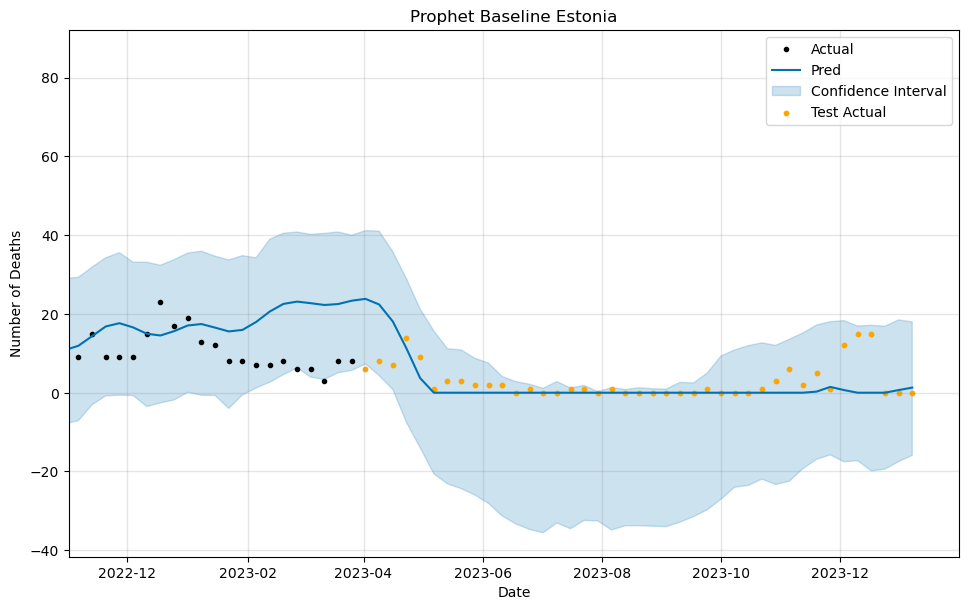

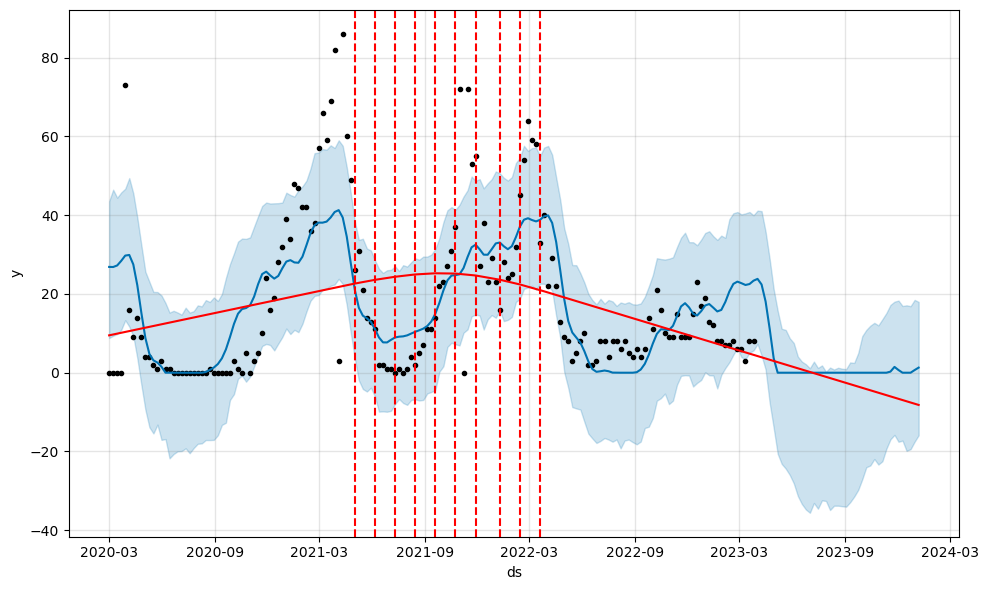

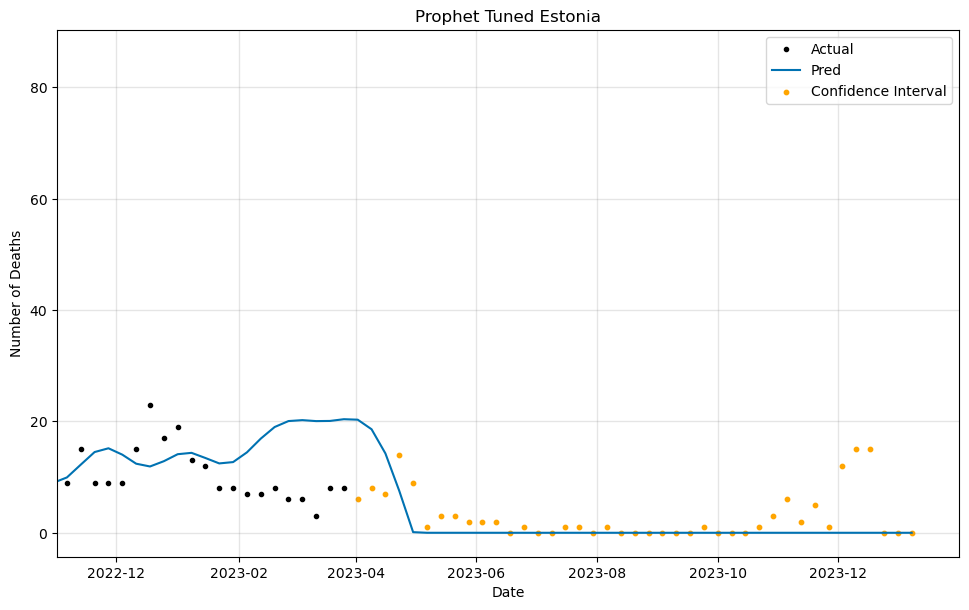

In [7]:
df = estonia 
train, test = df[0:train_size], df[train_size:]

# baseline prophet model
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(train)

# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Baseline Estonia')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':' Estonia', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)

# tuning prophet 

param_grid = {'changepoint_prior_scale': [0.01, 0.1, 0.5,1.0,10.0],
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='56 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
best_params = all_params[np.argmin(maes)]

model_changepoint = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], seasonality_prior_scale=best_params['seasonality_prior_scale'])
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint, uncertainty=False); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Tuned Estonia')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':' Estonia', 
                                'Model':'Tuned', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

# France

21:50:43 - cmdstanpy - INFO - Chain [1] start processing
21:50:44 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_20579/3701468698.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':' France',
21:50:44 - cmdstanpy - INFO - Chain [1] start processing
21:50:44 - cmdstanpy - INFO - Chain [1] done processing
21:50:46 - cmdstanpy - INFO - Chain [1] start processing
21:50:46 - cmdstanpy - INFO - Chain [1] start processing
21:50:46 - cmdstanpy - INFO - Chain [1] start processing
21:50:46 - cmdstanpy - INFO - Chain [1] s

,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.670420,0.198496
1,United States,Tuned,6637.052246,16182.511291,1.207254
2,Belgium,Baseline,57.538519,2312.254946,0.242626
3,Belgium,Tuned,8.642080,33.644019,0.036442
4,Chile,Baseline,214.633967,2422.805759,0.488097
5,Chile,Tuned,82.871212,497.925852,0.188457
6,Chile,Baseline,16.468927,71.162596,0.051739
7,Czechia,Tuned,16.507045,69.033493,0.051858
8,Estonia,Baseline,3.166873,51.833376,0.163366
9,Estonia,Tuned,3.061283,45.982188,0.157919


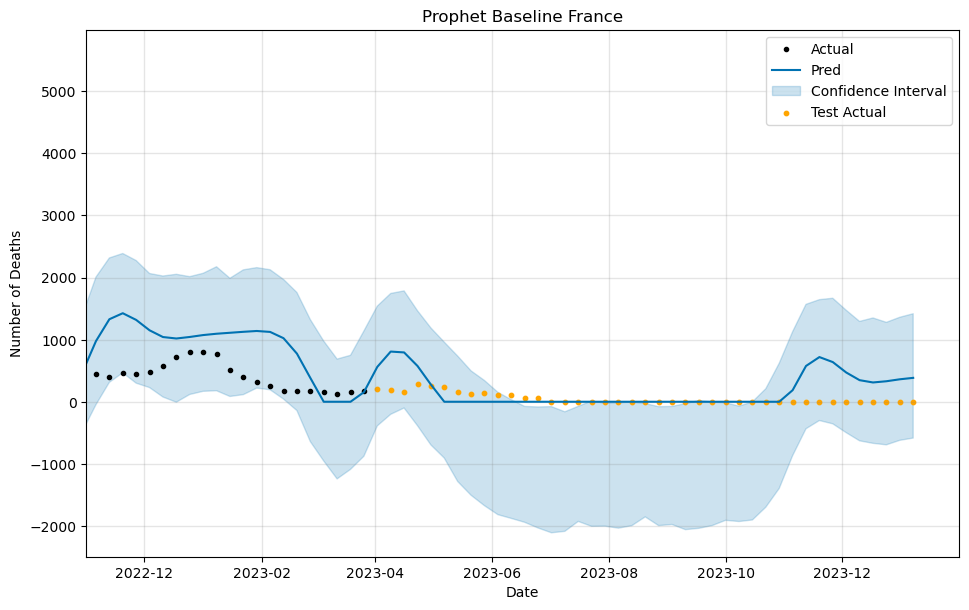

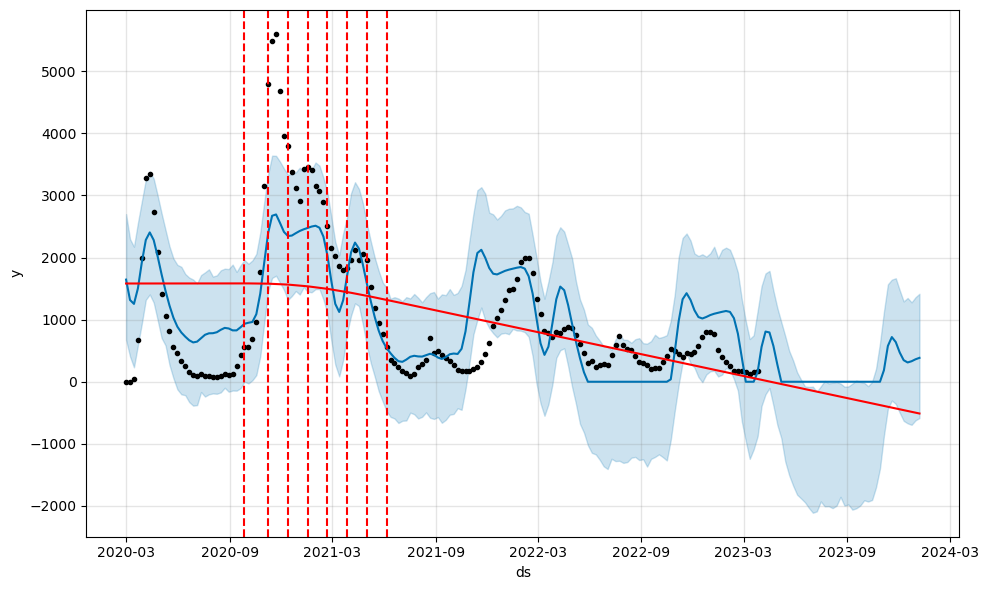

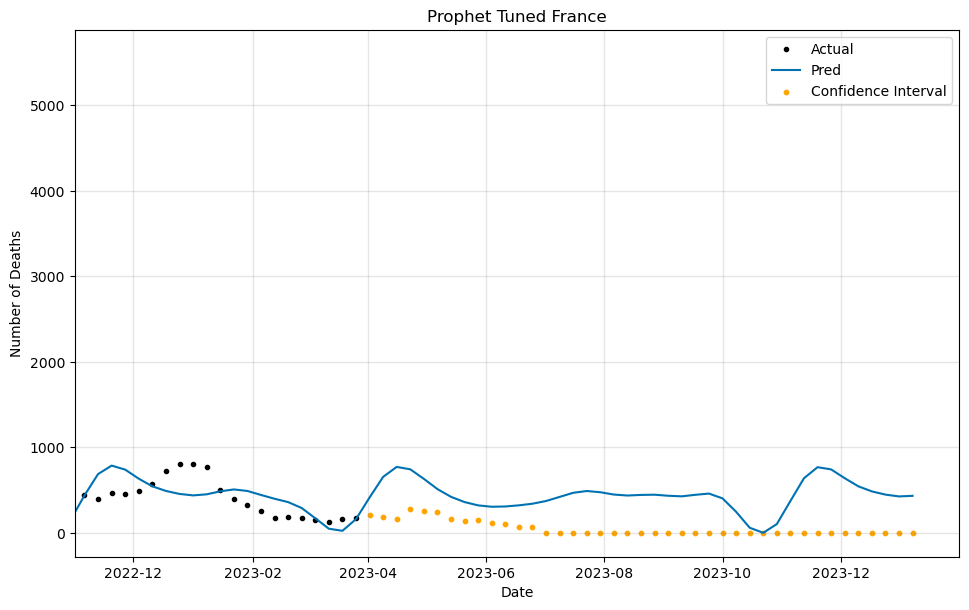

In [8]:
df = france 
train, test = df[0:train_size], df[train_size:]

# baseline prophet model
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(train)

# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Baseline France')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':' France', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)

# tuning prophet 

param_grid = {'changepoint_prior_scale': [0.01, 0.1, 0.5,1.0,10.0],
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='56 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
best_params = all_params[np.argmin(maes)]

model_changepoint = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], seasonality_prior_scale=best_params['seasonality_prior_scale'])
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint, uncertainty=False); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Tuned France')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':' France', 
                                'Model':'Tuned', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

# Ireland

21:52:13 - cmdstanpy - INFO - Chain [1] start processing
21:52:13 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_20579/852086528.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':' Ireland',
21:52:13 - cmdstanpy - INFO - Chain [1] start processing
21:52:13 - cmdstanpy - INFO - Chain [1] done processing
21:52:15 - cmdstanpy - INFO - Chain [1] start processing
21:52:15 - cmdstanpy - INFO - Chain [1] start processing
21:52:15 - cmdstanpy - INFO - Chain [1] start processing
21:52:15 - cmdstanpy - INFO - Chain [1] s

,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.670420,0.198496
1,United States,Tuned,6637.052246,16182.511291,1.207254
2,Belgium,Baseline,57.538519,2312.254946,0.242626
3,Belgium,Tuned,8.642080,33.644019,0.036442
4,Chile,Baseline,214.633967,2422.805759,0.488097
5,Chile,Tuned,82.871212,497.925852,0.188457
6,Chile,Baseline,16.468927,71.162596,0.051739
7,Czechia,Tuned,16.507045,69.033493,0.051858
8,Estonia,Baseline,3.166873,51.833376,0.163366
9,Estonia,Tuned,3.061283,45.982188,0.157919


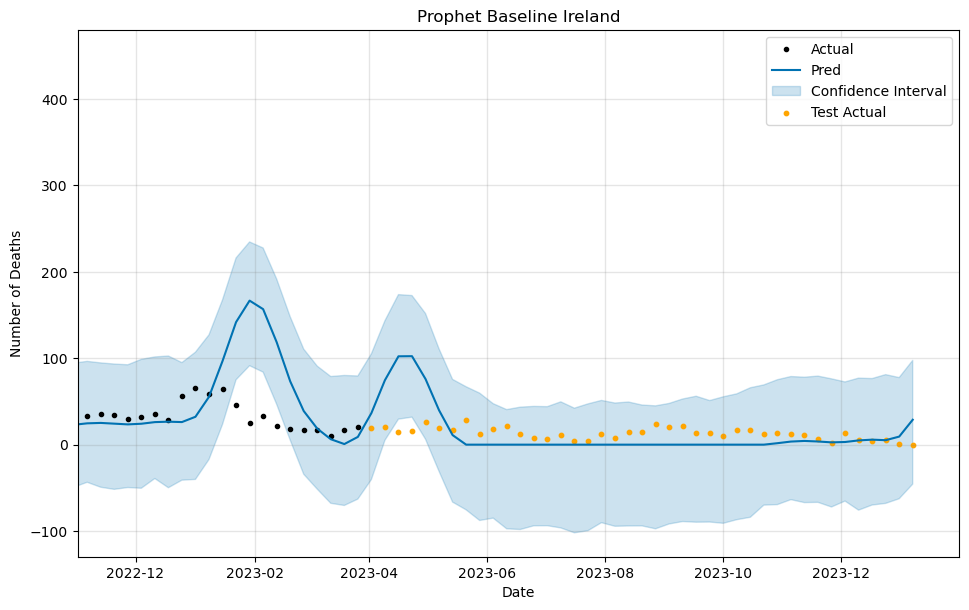

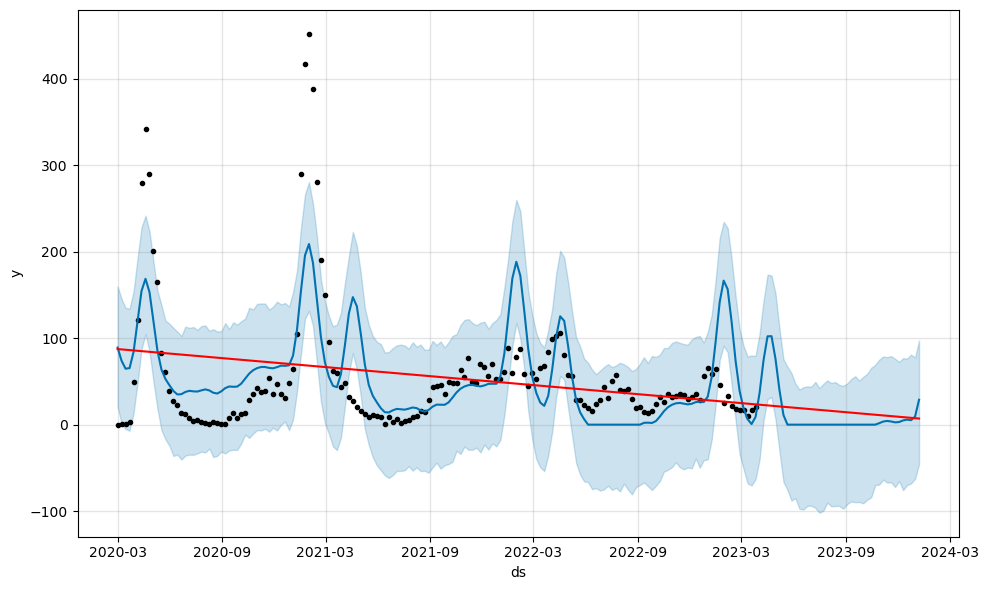

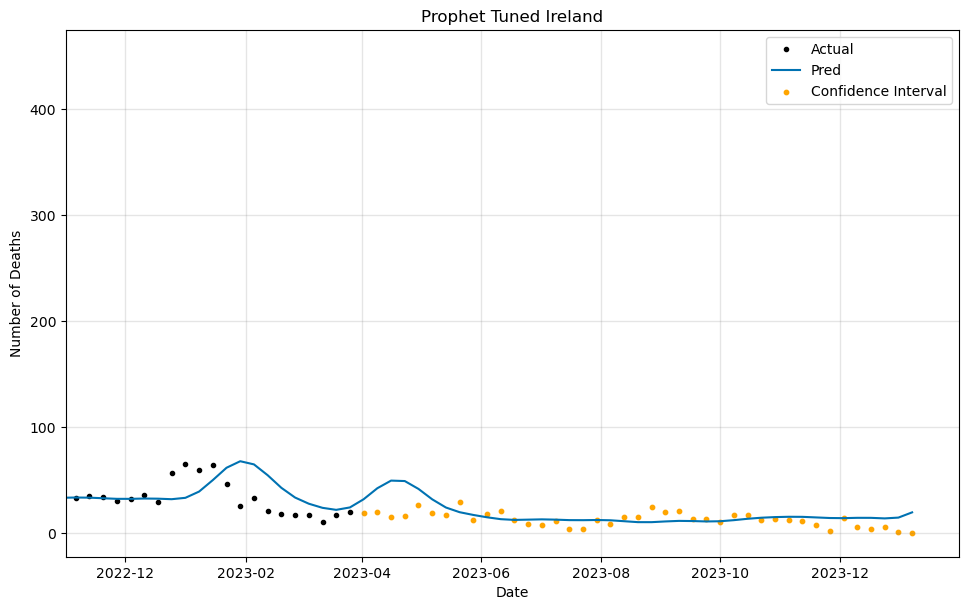

In [9]:
df = ireland 
train, test = df[0:train_size], df[train_size:]

# baseline prophet model
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(train)

# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Baseline Ireland')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':' Ireland', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)

# tuning prophet 

param_grid = {'changepoint_prior_scale': [0.01, 0.1, 0.5,1.0,10.0],
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='56 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
best_params = all_params[np.argmin(maes)]

model_changepoint = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], seasonality_prior_scale=best_params['seasonality_prior_scale'])
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint, uncertainty=False); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Tuned Ireland')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':' Ireland', 
                                'Model':'Tuned', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

# Israel

21:53:41 - cmdstanpy - INFO - Chain [1] start processing
21:53:41 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_20579/1668435313.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':' Israel',
21:53:41 - cmdstanpy - INFO - Chain [1] start processing
21:53:42 - cmdstanpy - INFO - Chain [1] done processing
21:53:43 - cmdstanpy - INFO - Chain [1] start processing
21:53:43 - cmdstanpy - INFO - Chain [1] start processing
21:53:43 - cmdstanpy - INFO - Chain [1] start processing
21:53:43 - cmdstanpy - INFO - Chain [1] s

,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.670420,0.198496
1,United States,Tuned,6637.052246,16182.511291,1.207254
2,Belgium,Baseline,57.538519,2312.254946,0.242626
3,Belgium,Tuned,8.642080,33.644019,0.036442
4,Chile,Baseline,214.633967,2422.805759,0.488097
5,Chile,Tuned,82.871212,497.925852,0.188457
6,Chile,Baseline,16.468927,71.162596,0.051739
7,Czechia,Tuned,16.507045,69.033493,0.051858
8,Estonia,Baseline,3.166873,51.833376,0.163366
9,Estonia,Tuned,3.061283,45.982188,0.157919


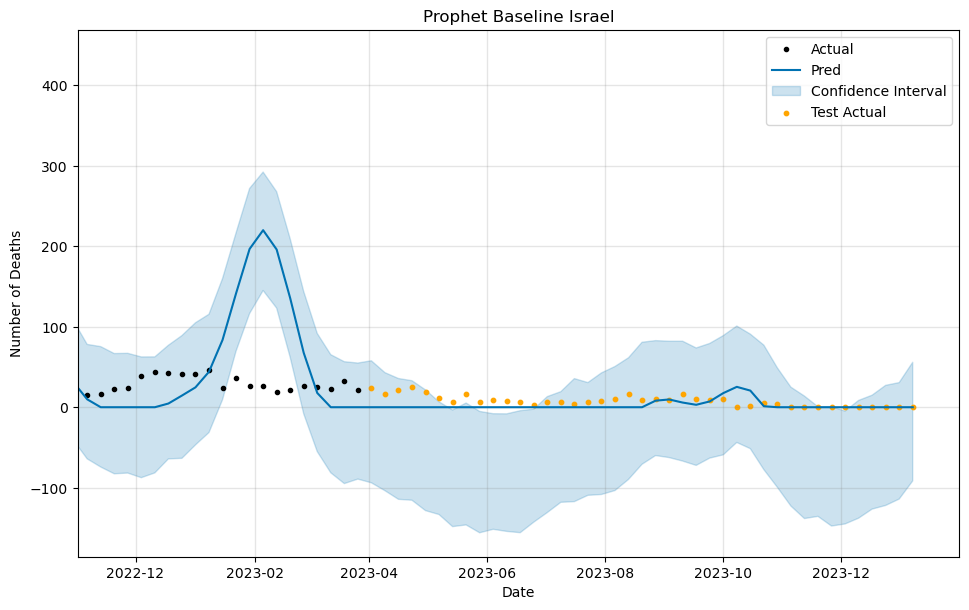

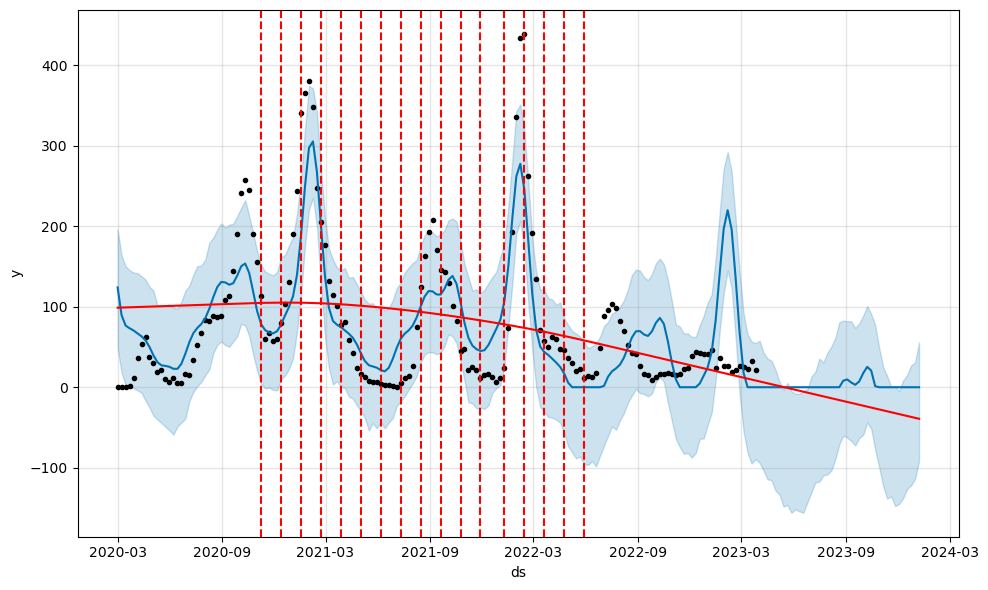

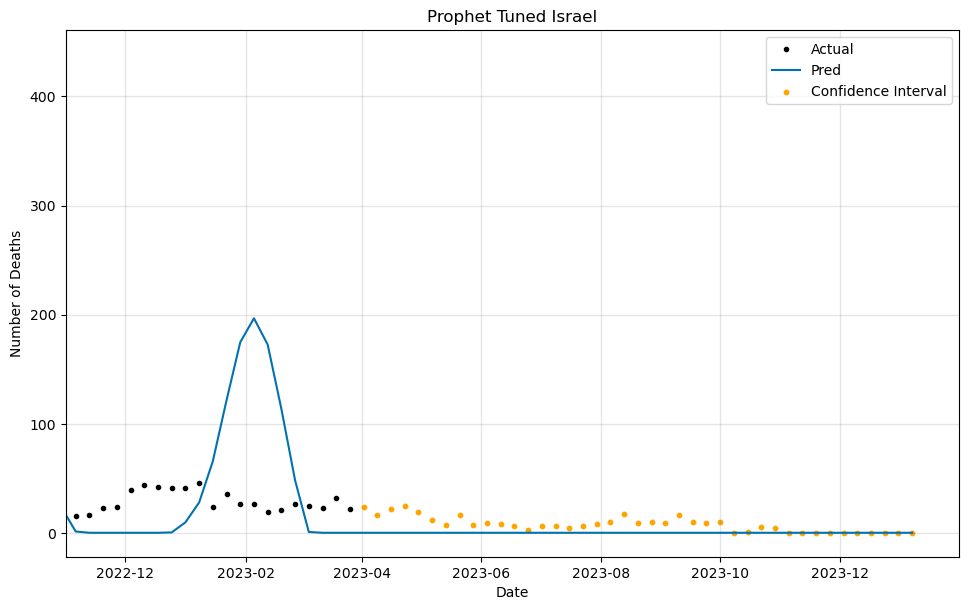

In [10]:
df = israel 
train, test = df[0:train_size], df[train_size:]

# baseline prophet model
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(train)

# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Baseline Israel')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':' Israel', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)

# tuning prophet 

param_grid = {'changepoint_prior_scale': [0.01, 0.1, 0.5,1.0,10.0],
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='56 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
best_params = all_params[np.argmin(maes)]

model_changepoint = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], seasonality_prior_scale=best_params['seasonality_prior_scale'])
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint, uncertainty=False); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Tuned Israel')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':' Israel', 
                                'Model':'Tuned', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

# Italy

21:55:15 - cmdstanpy - INFO - Chain [1] start processing


21:55:15 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_20579/2330439654.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':' Italy',
21:55:15 - cmdstanpy - INFO - Chain [1] start processing
21:55:15 - cmdstanpy - INFO - Chain [1] done processing
21:55:17 - cmdstanpy - INFO - Chain [1] start processing
21:55:17 - cmdstanpy - INFO - Chain [1] start processing
21:55:17 - cmdstanpy - INFO - Chain [1] start processing
21:55:17 - cmdstanpy - INFO - Chain [1] start processing
21:55:17 - cmdstanpy - INFO - Chain [1] st

,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.670420,0.198496
1,United States,Tuned,6637.052246,16182.511291,1.207254
2,Belgium,Baseline,57.538519,2312.254946,0.242626
3,Belgium,Tuned,8.642080,33.644019,0.036442
4,Chile,Baseline,214.633967,2422.805759,0.488097
5,Chile,Tuned,82.871212,497.925852,0.188457
6,Chile,Baseline,16.468927,71.162596,0.051739
7,Czechia,Tuned,16.507045,69.033493,0.051858
8,Estonia,Baseline,3.166873,51.833376,0.163366
9,Estonia,Tuned,3.061283,45.982188,0.157919


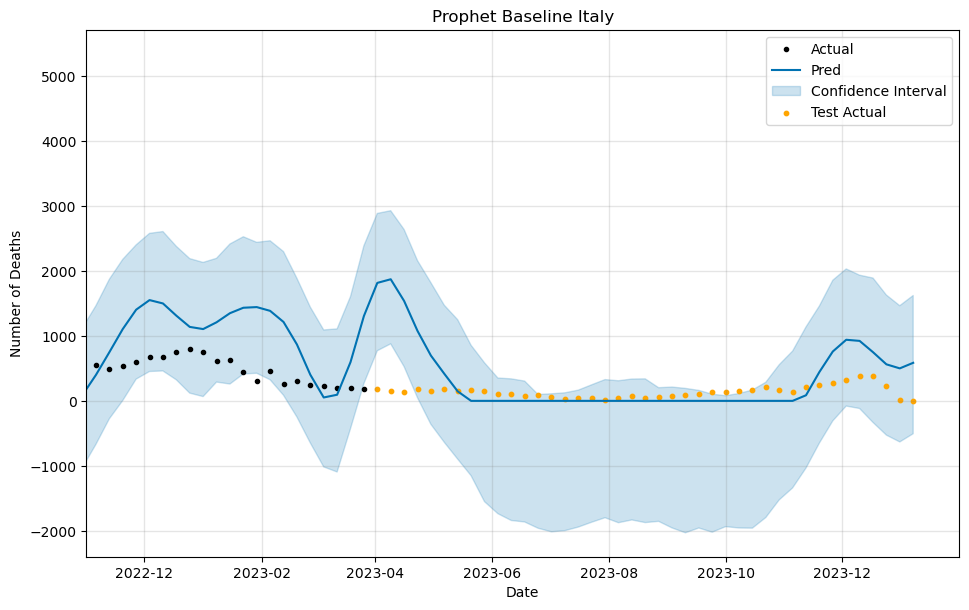

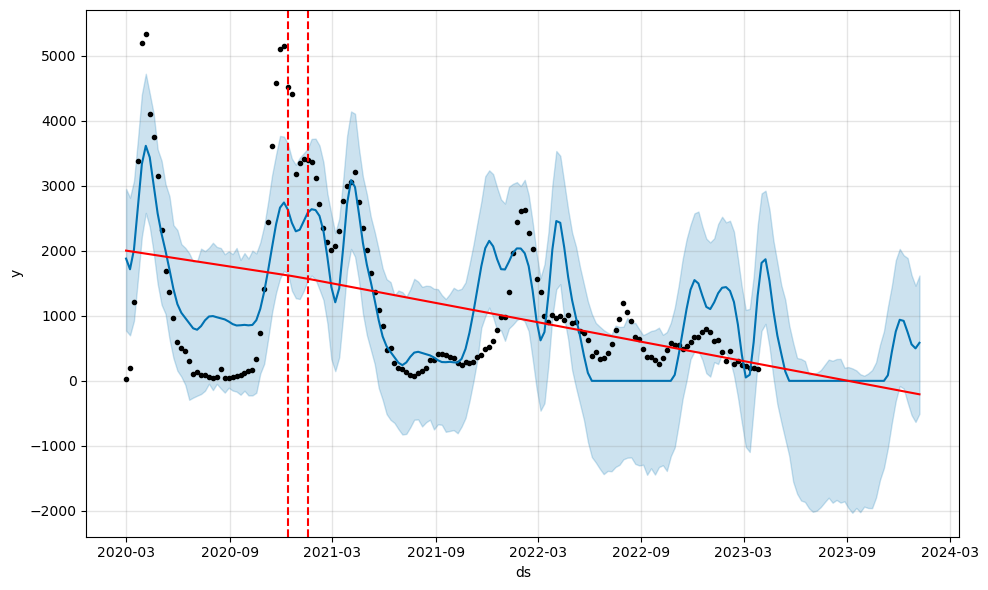

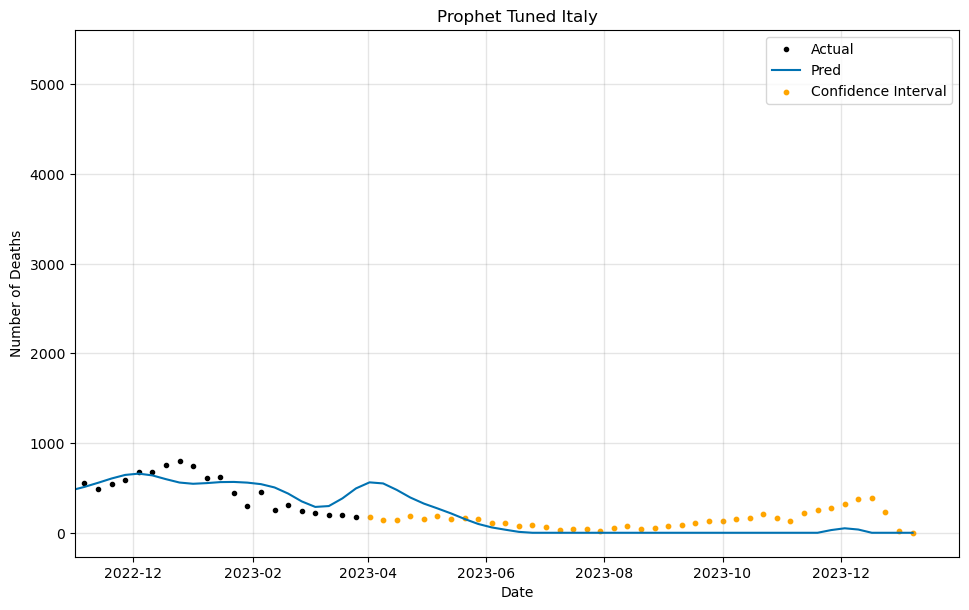

In [11]:
df = italy 
train, test = df[0:train_size], df[train_size:]

# baseline prophet model
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(train)

# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Baseline Italy')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':' Italy', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)

# tuning prophet 

param_grid = {'changepoint_prior_scale': [0.01, 0.1, 0.5,1.0,10.0],
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='56 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
best_params = all_params[np.argmin(maes)]

model_changepoint = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], seasonality_prior_scale=best_params['seasonality_prior_scale'])
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint, uncertainty=False); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Tuned Italy')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':' Italy', 
                                'Model':'Tuned', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

# Malaysia 

21:56:58 - cmdstanpy - INFO - Chain [1] start processing


21:56:58 - cmdstanpy - INFO - Chain [1] done processing
/Users/yui/miniconda3/envs/py38/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_20579/3141018812.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation = evaluation.append({'Country':' Malaysia',
21:56:58 - cmdstanpy - INFO - Chain [1] start processing
21:56:58 - cmdstanpy - INFO - Chain [1] done processing
21:57:01 - cmdstanpy - INFO - Chain [1] start processing
21:57:01 - cmdstanpy - INFO - Chain [1] start processing
21:57:01 - cmdstanpy - INFO - Chain [1] start processing
21:57:01 - cmdstanpy - INFO - Chain [1] start processing
21:57:01 - cmdstanpy - INFO - Chain [1]

,Country,Model,MAE,MAPE,MASE
0,United States,Baseline,1091.260702,4511.670420,0.198496
1,United States,Tuned,6637.052246,16182.511291,1.207254
2,Belgium,Baseline,57.538519,2312.254946,0.242626
3,Belgium,Tuned,8.642080,33.644019,0.036442
4,Chile,Baseline,214.633967,2422.805759,0.488097
5,Chile,Tuned,82.871212,497.925852,0.188457
6,Chile,Baseline,16.468927,71.162596,0.051739
7,Czechia,Tuned,16.507045,69.033493,0.051858
8,Estonia,Baseline,3.166873,51.833376,0.163366
9,Estonia,Tuned,3.061283,45.982188,0.157919


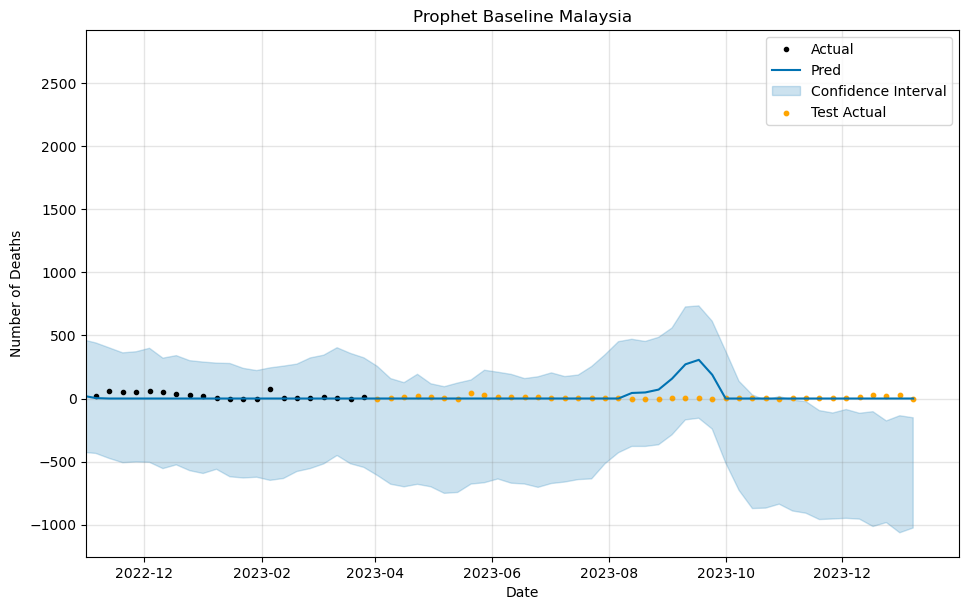

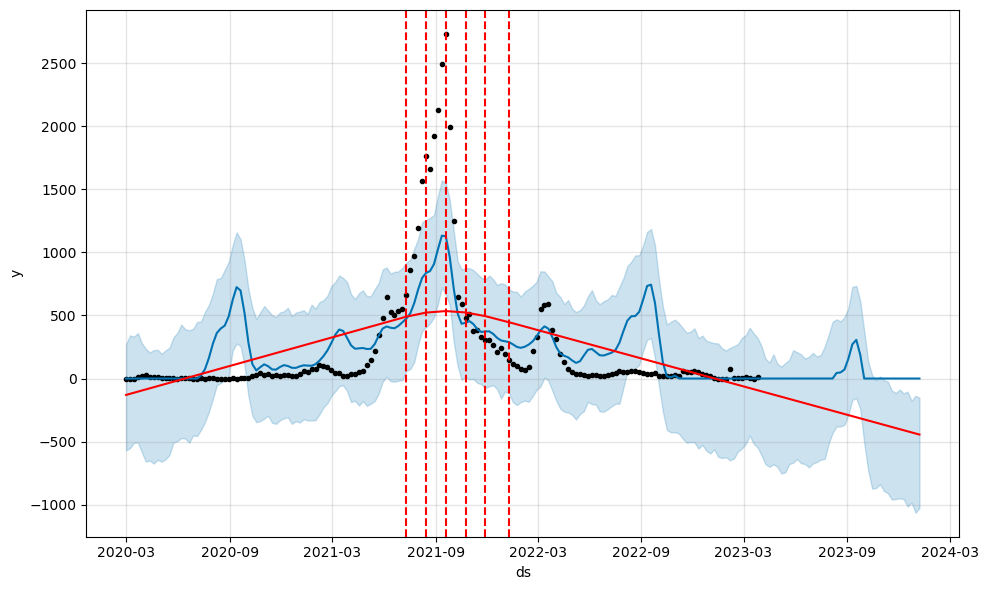

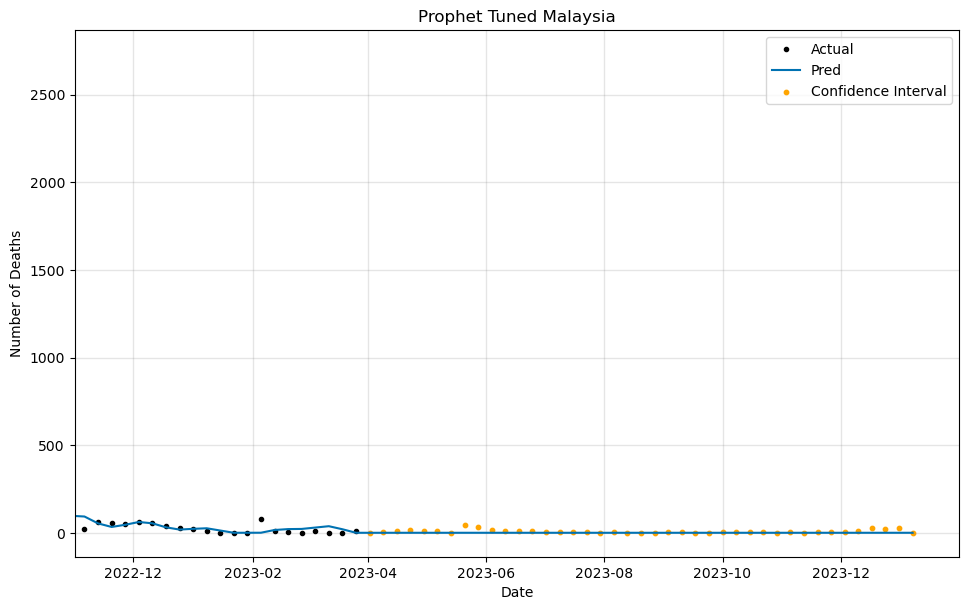

In [12]:
df = malaysia 
train, test = df[0:train_size], df[train_size:]

# baseline prophet model
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(train)

# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
forecast_baseline['yhat'] = forecast_baseline['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Baseline Malaysia')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MAPE = mape(performance_baseline['y'], performance_baseline['yhat'])
performance_baseline_MASE = mase(performance_baseline['y'], performance_baseline['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':' Malaysia', 
                                'Model':'Baseline', 'MAE':performance_baseline_MAE, 
                                'MAPE':performance_baseline_MAPE, 
                                'MASE':performance_baseline_MASE}, ignore_index=True)

# Changepoints 
# Default change points
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)

# tuning prophet 

param_grid = {'changepoint_prior_scale': [0.01, 0.1, 0.5,1.0,10.0],
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='56 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
best_params = all_params[np.argmin(maes)]

model_changepoint = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], seasonality_prior_scale=best_params['seasonality_prior_scale'])
# Fit the model using the training dataset
model_changepoint.fit(train)
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=len(test), freq='W')
# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)
# Replace negative values with 0
forecast_changepoint['yhat'] = forecast_changepoint['yhat'].apply(lambda x: 0 if x < 0 else x)
# Visualize the forecast
model_changepoint.plot(forecast_changepoint, uncertainty=False); # Visualize the forecast components
plt.scatter(test['ds'], test['y'], label='Actual', color='orange', s=10)
plt.legend(['Actual', 'Pred','Confidence Interval','Test Actual'])
# x axis rename to date
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Prophet Tuned Malaysia')
# make that same plot but starting at jan 2023
plt.xlim(pd.to_datetime('2022-11-01'), pd.to_datetime('2024-01-31'))
# performance eval 
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MAPE = mape(performance_changepoint['y'], performance_changepoint['yhat'])
performance_changepoint_MASE = mase(performance_changepoint['y'], performance_changepoint['yhat'], y_train = train['y'])
evaluation = evaluation.append({'Country':' Malaysia', 
                                'Model':'Tuned', 
                                'MAE':performance_changepoint_MAE, 
                                'MAPE':performance_changepoint_MAPE,
                                'MASE':performance_changepoint_MASE}, ignore_index=True)
evaluation

In [18]:
# get evaluation where model is baseline
# round to 4 decimal places
evaluation = evaluation.round(4)
baseline = evaluation[evaluation['Model'] == 'Baseline']
tuned = evaluation[evaluation['Model'] == 'Tuned']
# to csv
# evaluation.to_csv('prophet_evaluation.csv', index=False)



In [31]:
evaluation.mean()

/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_20579/852982711.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  evaluation.mean()


MAE      461.575065
MAPE    3507.060825
MASE       0.222790
dtype: float64

In [29]:
baseline.median()

/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_20579/1852771762.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  baseline.median()


MAE       45.65905
MAPE    1596.23700
MASE       0.18530
dtype: float64

In [30]:
tuned.median()

/var/folders/8k/n_ksdn3d24l74_zsdlmr7drh0000gn/T/ipykernel_20579/2433204635.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  tuned.median()


MAE     12.57455
MAPE    83.22785
MASE     0.13025
dtype: float64